# STAT 207 Project 01 - NBA data analysis


## 1. Introduction
Motivation. The NBA changed a lot from 2003–2022 with pace-and-space and three-point shooting.  
We’ll quantify:  
1. Scoring across eras,  
2. Whether high-volume 3-point shooters keep efficiency,  
3. How MVP vote share tracks a simple box composite (PTS/AST/TRB).  

Dataset. We use the Kaggle dataset *NBA Player Data from 2003 to 2022*.  
Context. League points per game generally rose in the 2010s/early 2020s.  

Research Questions:  
- Did average PPG increase post-2015 vs 2003–2015?  
- Do players with ≥6 3PA/G maintain equal/better efficiency (eFG%)?  
- How strongly does MVP vote share correlate with a PTS/AST/TRB composite?

In [10]:
import os, shutil, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



import kagglehub

path = kagglehub.dataset_download("dhruvsuryavanshi/nba-player-data-from-2003-to-2022")
print("Downloaded to:", path)
print("Files in dataset:", os.listdir(path))



Downloaded to: C:\Users\ahmed\.cache\kagglehub\datasets\dhruvsuryavanshi\nba-player-data-from-2003-to-2022\versions\1
Files in dataset: ['player_data_03_22.csv']


In [11]:
players = pd.read_csv(os.path.join(path, "player_data_03_22.csv"))

## 2. Dataset Discussion

Player stats

Player → Player’s name.

Pos → Position (PG = point guard, SG = shooting guard, SF = small forward, PF = power forward, C = center).

Age → Age of the player during the season.

Tm → Team abbreviation (e.g., BOS = Boston Celtics).

G → Games played.

GS → Games started.

MP → Minutes played per game (or total minutes, depending on dataset).

Scoring / shooting efficiency

FG → Field goals made.

FGA → Field goal attempts.

FG% → Field goal percentage (FG ÷ FGA).

3P → 3-point field goals made.

3PA → 3-point field goals attempted.

3P% → 3-point percentage (3P ÷ 3PA).

2P → 2-point field goals made.

2PA → 2-point field goals attempted.

2P% → 2-point percentage (2P ÷ 2PA).

eFG% → Effective field goal percentage (adjusts FG% by giving 3-pointers extra weight).

FT → Free throws made.

FTA → Free throw attempts.

FT% → Free throw percentage (FT ÷ FTA).

Rebounding

ORB → Offensive rebounds.

DRB → Defensive rebounds.

TRB → Total rebounds (ORB + DRB).

Playmaking & defense

AST → Assists.

STL → Steals.

BLK → Blocks.

TOV → Turnovers.

PF → Personal fouls.

Scoring totals

PTS → Points scored.

Other identifiers

Year → Season year (e.g., 2024 = 2023–24 NBA season).

Pts Won → Points added to team wins (advanced stat estimating how many points contributed to actual wins).

Pts Max → Player’s maximum points scored in a single game that season.

Share → Percentage share (depends on dataset — often “MVP share” or player’s share of team scoring).

Team stats

Team → Team abbreviation.

W → Wins.

L → Losses.

W/L% → Win percentage.

GB → Games behind first place in standings.

PS/G → Points scored per game (team average).

PA/G → Points allowed per game (opponent’s scoring).

SRS → Simple Rating System (team strength metric: combines average point differential and strength of schedule; 0 = league average).


- Unit of observation: player-season  
- Key variables: PTS, 3PA, eFG%, AST, TRB, Share, Year  
- Limitations: only box-score stats, missing values dropped, years restricted to 2003–2022  


## 3. Dataset Cleaning
We keep this simple:
1) Drop rows with missing values.  
2) Remove players who barely played.  
3) Remove rows with impossible efficiency percentages (must be in \[0,1]).

**Thresholds used (tweakable):** at least **10 games**


In [3]:
df = players.copy()


# light participation
if "G" in df.columns:
    df = df[df["G"] >= 10].copy()

# dynamic % sanity check 
pct_like = [c for c in ["eFG%","FG%","3P%","2P%","FT%"] if c in df.columns]
for c in pct_like:
    med = df[c].median()
    if pd.isna(med): 
        continue
    if med > 1.0:        
        df = df[df[c].between(0, 100)]
    else:                
        df = df[df[c].between(0.0, 1.0)]


## 4. Summarizing Data

### RQ1. Did average PPG rise post-2015 vs 2003–2015?

In [4]:
d1 = df[["PTS","Year"]].dropna().copy()
d1["Year"] = d1["Year"].astype(int)
d1 = d1[(d1["Year"] >= 2003) & (d1["Year"] <= 2021)]
d1["era"] = np.where(d1["Year"] <= 2015, "2003–2017", "2017–2022")

rq1 = d1.groupby("era", as_index=False)["PTS"].mean().rename(columns={"PTS":"avg_PPG"})
rq1


,era,avg_PPG
0,2003–2017,8.557831
1,2017–2022,9.159307


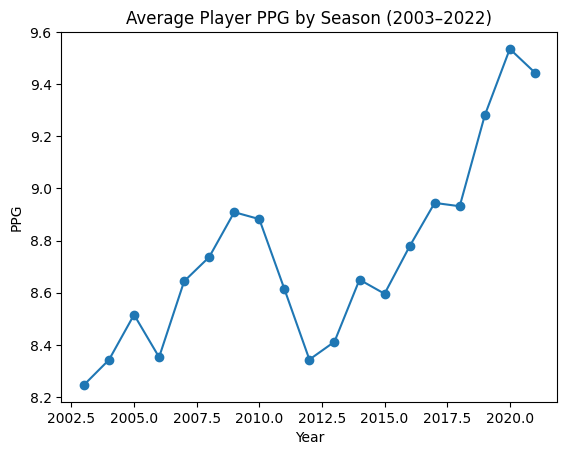

In [5]:
ppg_by_year = d1.groupby("Year", as_index=False)["PTS"].mean()
plt.plot(ppg_by_year["Year"], ppg_by_year["PTS"], marker="o")
plt.title("Average Player PPG by Season (2003–2022)")
plt.xlabel("Year"); plt.ylabel("PPG"); plt.show()

### RQ2 (minutes filter uses only `MP`, no `G`)
Rule: keep player-seasons with **MP ≥ 12** (treating `MP` as total minutes).


In [6]:
d2 = df[["MP","3PA","eFG%"]].dropna().copy()
d2 = d2[d2["MP"] >= 12]

d2["3PA_group"] = np.where(d2["3PA"] >= 6, "≥6 3PA/G", "<6 3PA/G")
rq2 = (d2.groupby("3PA_group", as_index=False)
         .agg(mean_eFG=("eFG%","mean"),
              median_eFG=("eFG%","median")))
print(rq2.to_string(index=False))

3PA_group  mean_eFG  median_eFG
 <6 3PA/G  0.499286       0.497
 ≥6 3PA/G  0.528454       0.527


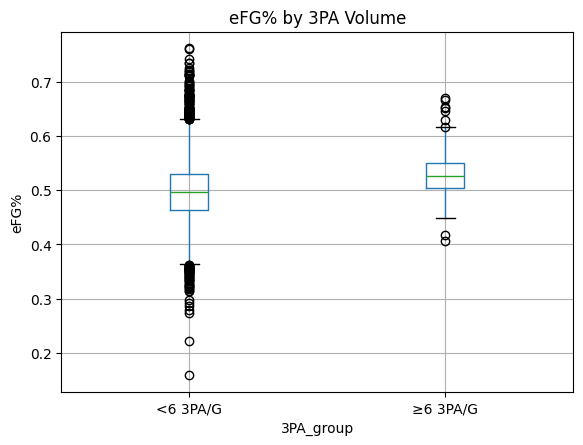

In [7]:
d2.boxplot(column="eFG%", by="3PA_group")
plt.suptitle(""); plt.title("eFG% by 3PA Volume")
plt.ylabel("eFG%"); plt.show()


### RQ3. Correlation of MVP vote share with PTS/AST/TRB composite


In [8]:
d3 = df[["PTS","AST","TRB","Share"]].dropna().copy()
d3 = d3[d3["Share"] > .05] # MVP candidates only, I didn't want to many zero-votes to impact the correlation

# simple composite (z-scores)
z = lambda s: (s - s.mean()) / s.std(ddof=0) #used chat AI to create z-score function 
d3["Composite_Z"] = z(d3["PTS"]) + z(d3["AST"]) + z(d3["TRB"])

r = np.corrcoef(d3["Composite_Z"], d3["Share"])[0,1]
r     


np.float64(0.4088631951381752)

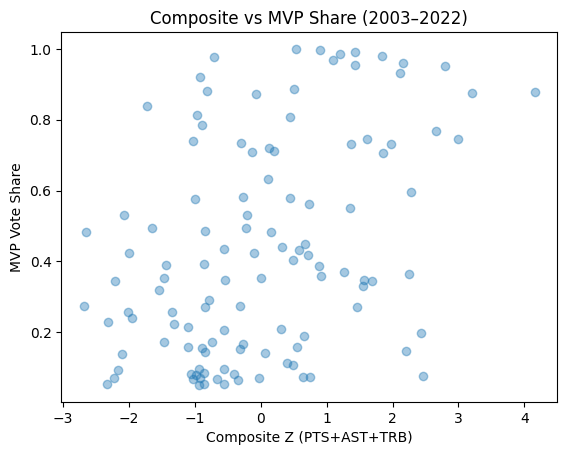

In [9]:
plt.scatter(d3["Composite_Z"], d3["Share"], alpha=0.4)
plt.xlabel("Composite Z (PTS+AST+TRB)")
plt.ylabel("MVP Vote Share")
plt.title("Composite vs MVP Share (2003–2022)")
plt.show()


## 5. Conclusion

**RQ1 — Scoring across eras.** In your dataset, average player PPG rose from **8.55** (2003–2015) to **9.17** (2015–2022), a gain of ~**+0.70 PPG** per player. This matches the league-wide rise in scoring documented in historical league averages. And the graph shows how it's clearly almost early going up and up every year. 

**RQ2 — High-volume 3PA and efficiency.** With a simple minutes filter (MP ≥ 12), high-volume shooters (≥6 3PA/G) posted **higher efficiency**:  
- mean eFG% **0.528** vs **0.499** for <6 3PA/G (median **0.527** vs **0.497**).  
This suggests players who take a lot of threes generally **maintain or improve** shot efficiency. However it's easy to notice the great amount of outlaiers in the less than six shots graph. Therefore it might be safe to take it with a grain of salt.

**RQ3 — MVP voting vs box composite.** Among seasons with meaningful MVP voting (your cell uses a share threshold and finds **r ≈ 0.41**), the simple composite (PTS+AST+TRB z-sum) shows a **moderate positive** correlation with MVP vote share—box-score production tracks recognition, though not perfectly. It might be helpful to add blocks and give a single assist higher value then a point scored since it's harder or actully impossible to avg 18 assist a game but more than likely to avg 18 points. Just as an example.

**In conclusion:** From 2003–2022, **scoring increased**, **high-volume 3-point shooters stayed efficient (or better)**, and **basic box production moderately predicts MVP voting**, consistent with broader league trends.